In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score, precision_recall_curve, average_precision_score
)

In [52]:
TEST_SPLIT_SIZE = 0.3
RANDOM_STATE = 30

## Data and Preprocessing

In [53]:
%pip install ucimlrepo

from IPython.display import clear_output
clear_output()

from ucimlrepo import fetch_ucirepo

In [54]:
df = fetch_ucirepo(id=350)

X = df.data.features 
y = df.data.targets

print(X.shape)
X.head()

(30000, 23)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [55]:
mapping = df.variables.set_index("name")["description"]

X = X.rename(columns=mapping)
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [56]:
y = y["Y"]
y.shape, y.unique()

((30000,), array([1, 0]))

In [57]:
NUMERIC_COLS = X.select_dtypes(include='number').columns
CATEGORICAL_COLS = X.select_dtypes(include='category').columns # No categorical columns in this dataset

NUMERIC_COLS, CATEGORICAL_COLS

(Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
        'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
        'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
        'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
       dtype='object'),
 Index([], dtype='object'))

In [58]:
X.describe().round(2)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,...,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00
mean,167484.32,1.60,1.85,1.55,35.49,-0.02,-0.13,-0.17,-0.22,-0.27,...,47013.15,43262.95,40311.40,38871.76,5663.58,5921.16,5225.68,4826.08,4799.39,5215.50
std,129747.66,0.49,0.79,0.52,9.22,1.12,1.20,1.20,1.17,1.13,...,69349.39,64332.86,60797.16,59554.11,16563.28,23040.87,17606.96,15666.16,15278.31,17777.47
min,10000.00,1.00,0.00,0.00,21.00,-2.00,-2.00,-2.00,-2.00,-2.00,...,-157264.00,-170000.00,-81334.00,-339603.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,50000.00,1.00,1.00,1.00,28.00,-1.00,-1.00,-1.00,-1.00,-1.00,...,2666.25,2326.75,1763.00,1256.00,1000.00,833.00,390.00,296.00,252.50,117.75
50%,140000.00,2.00,2.00,2.00,34.00,0.00,0.00,0.00,0.00,0.00,...,20088.50,19052.00,18104.50,17071.00,2100.00,2009.00,1800.00,1500.00,1500.00,1500.00
75%,240000.00,2.00,2.00,2.00,41.00,0.00,0.00,0.00,0.00,0.00,...,60164.75,54506.00,50190.50,49198.25,5006.00,5000.00,4505.00,4013.25,4031.50,4000.00
max,1000000.00,2.00,6.00,3.00,79.00,8.00,8.00,8.00,8.00,8.00,...,1664089.00,891586.00,927171.00,961664.00,873552.00,1684259.00,896040.00,621000.00,426529.00,528666.00


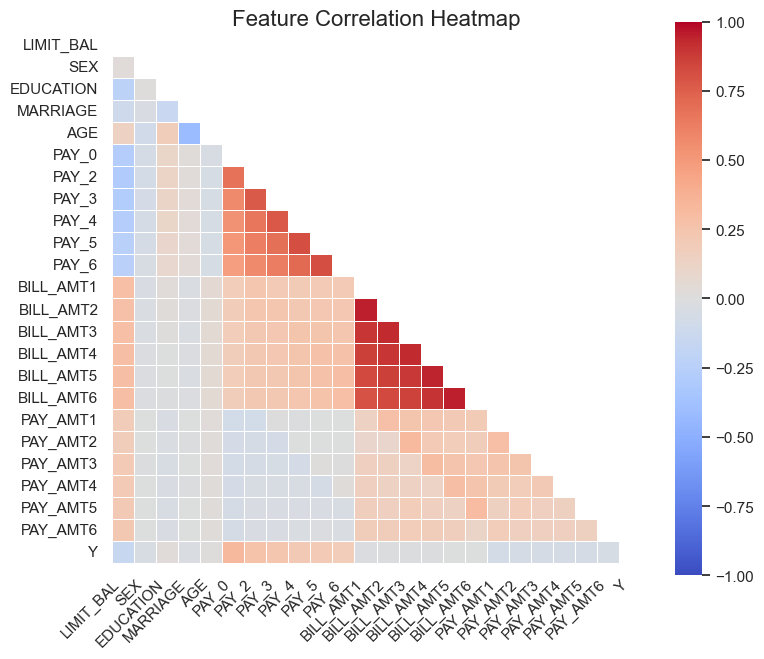

In [114]:
plt.figure(figsize=(8, 8))
sns.set_theme(style="white")

temp = pd.concat([X, y], axis=1)

corr = temp.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    center=0,
    vmax=1.0,
    vmin=-1.0,
    annot=False,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
    square=True
)

plt.title("Feature Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SPLIT_SIZE, random_state=RANDOM_STATE, stratify=y
)

In [60]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Helper function to evaluate model performance

def eval(model, X, y):
    predicted = model.predict(X)
    accuracy = accuracy_score(y, predicted)
    report = classification_report(y, predicted)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {roc_auc_score(y, model.predict_proba(X)[:, 1]):.4f}")
    print("Classification Report:")
    print(report)

# Models

In [82]:
models = {}

## Logistic Regression

In [80]:
from sklearn.linear_model import LogisticRegression

In [84]:
log_reg = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
log_reg.fit(X_train, y_train)

models['Logistic Regression'] = log_reg

In [64]:
eval(log_reg, X_test, y_test)

Accuracy: 0.8134
AUC: 0.7319
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      7009
           1       0.76      0.23      0.35      1991

    accuracy                           0.81      9000
   macro avg       0.79      0.60      0.62      9000
weighted avg       0.80      0.81      0.77      9000



## Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [66]:
'''
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=RANDOM_STATE)

# Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Use all processors
    verbose=2
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")
print(f"Test Score: {grid_search.best_estimator_.score(X_test, y_test):.4f}")
'''

'\nparam_grid = {\n    \'n_estimators\': [10, 50, 100, 200],\n    \'max_depth\': [5, 10, 15, None],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4]\n}\n\nrf = RandomForestClassifier(random_state=RANDOM_STATE)\n\n# Grid Search with cross-validation\ngrid_search = GridSearchCV(\n    estimator=rf,\n    param_grid=param_grid,\n    cv=5,\n    scoring=\'accuracy\',\n    n_jobs=-1,  # Use all processors\n    verbose=2\n)\n\n# Fit the grid search\ngrid_search.fit(X_train, y_train)\n\n# Results\nprint(f"Best Parameters: {grid_search.best_params_}")\nprint(f"Best CV Score: {grid_search.best_score_:.4f}")\nprint(f"Test Score: {grid_search.best_estimator_.score(X_test, y_test):.4f}")\n'

In [86]:
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=5,
    random_state=RANDOM_STATE
    )
rf.fit(X_train, y_train)

models['Random Forest'] = rf

In [68]:
eval(rf, X_test, y_test)

feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

feat_importance.head(3)

Accuracy: 0.8232
AUC: 0.7839
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      7009
           1       0.70      0.36      0.47      1991

    accuracy                           0.82      9000
   macro avg       0.77      0.66      0.68      9000
weighted avg       0.81      0.82      0.80      9000



,Feature,Importance
5,PAY_0,0.241157
6,PAY_2,0.106139
7,PAY_3,0.054423


In [116]:
feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feat_importance.head(10).to_string(index=False))


Top 10 Most Important Features:
  Feature  Importance
    PAY_0    0.241157
    PAY_2    0.106139
    PAY_3    0.054423
    PAY_5    0.049966
    PAY_4    0.046821
 PAY_AMT1    0.045308
BILL_AMT1    0.038096
LIMIT_BAL    0.037839
BILL_AMT2    0.035061
 PAY_AMT2    0.034932


## KNN

In [87]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
mapping = df.variables.set_index("name")["description"]

X = X.rename(columns=mapping)
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [88]:
param_grid = {
    'n_neighbors': [1, 5, 10, 20, 50]
}

knn = KNeighborsClassifier()

# Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Use all processors
    verbose=2
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")
print(f"Test Score: {grid_search.best_estimator_.score(X_test, y_test):.4f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'n_neighbors': 20}
Best CV Score: 0.8076
Test Score: 0.8148


In [89]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

models['K-Nearest Neighbors'] = knn

In [90]:
eval(knn, X_test, y_test)

Accuracy: 0.7943
AUC: 0.7098
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      7009
           1       0.56      0.35      0.43      1991

    accuracy                           0.79      9000
   macro avg       0.69      0.64      0.65      9000
weighted avg       0.77      0.79      0.78      9000



# Results

In [92]:
models.keys()

dict_keys(['Logistic Regression', 'Random Forest', 'K-Nearest Neighbors'])

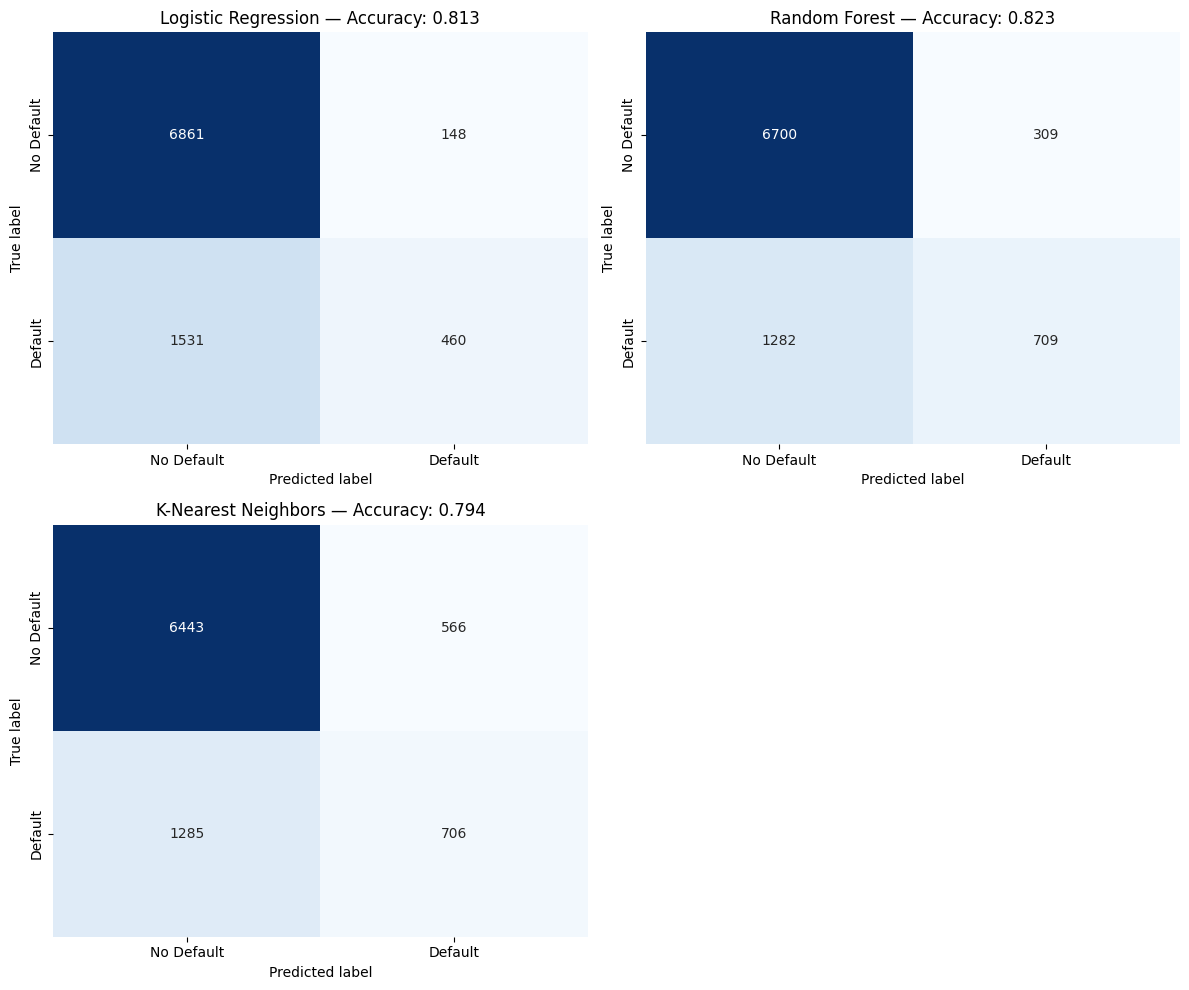

In [ ]:
import numpy as np

n_models = len(models)
cols = 2
rows = int(np.ceil(n_models / cols))

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axes = axes.flatten() if n_models > 1 else [axes]

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    # heatmap of raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
                xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(f"{name} — Accuracy: {acc:.3f}")

# Turn off any unused axes
for i in range(len(models), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

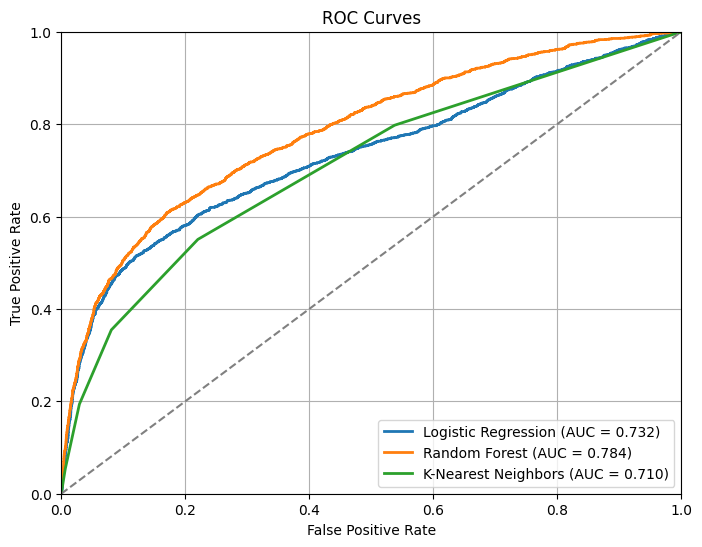

In [99]:
# Plot overlayed ROC curves for all trained models with diagonal dashed line
fig, ax = plt.subplots(figsize=(8, 6))

for name, model in models.items():
    # get probabilities for the positive class
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)[:, 1]
    else:
        # fallback to decision_function if predict_proba not available
        probs = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

# Plot diagonal (random guess) line
ax.plot([0, 1], [0, 1], linestyle="--", color="gray")

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves")
ax.legend(loc="lower right")
ax.grid(True)
plt.show()

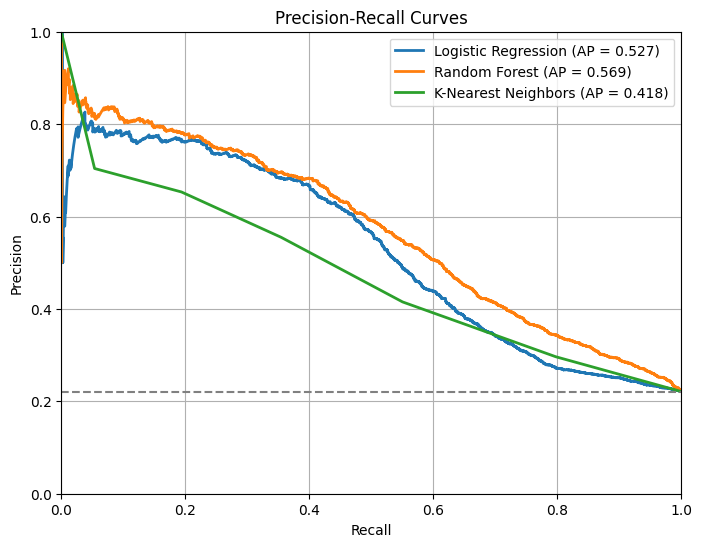

In [108]:
# Plot overlayed Precision-Recall curves for all trained models
fig, ax = plt.subplots(figsize=(8, 6))

for name, model in models.items():
    # get probabilities for the positive class
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)[:, 1]
    else:
        # fallback to decision_function if predict_proba not available
        probs = model.decision_function(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)
    ax.plot(recall, precision, lw=2, label=f"{name} (AP = {ap:.3f})")

# Plot no-skill baseline
no_skill = (y_test == 1).sum() / len(y_test)
ax.axhline(y=no_skill, linestyle="--", color="gray")

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curves")
ax.legend(loc="best")
ax.grid(True)
plt.show()